# Задание 4

## 1. Декоратор @cached (0.3 балла)

#### Реализуйте класс для хранения результатов выполнения функции

* max_count - максимальное число хранимых результатов. Если число результатов превышает max_count, требуется выбросить первый результат, т. е. в кеше должно храниться не более max_count последних результатов.
* продумайте архитектуру кеша так, чтобы для функций:

<code>
@cached
def f1():
    pass

@cached
def f2():
    pass
</code>    
должны иметь по max_count хранимых последних результатов, и т. д.

<b>P. S.</b>

* Считайте, что функция не имеет состояния (зависит только от передаваемых в нее аргументов).
* Храните данные так, чтобы из функции нельзя напрямую было получить закешированные результаты (только через \_\_closer\_\_).

<b>Рекомендации:</b>

* Для хранения данных используйте OrderedDict.
* Декорируйте wrapper с @functools.wraps(func)

In [1]:
from collections import OrderedDict

class LruCache(object):
    cache = OrderedDict()
    size_limit = 0
    
    def __init__(self, max_count):
        self.size_limit = max_count

    def __getitem__(self, key):
        return self.cache[key]
        
    def __setitem__(self, key, value):
        self.cache[key] = value
            
        if len(self.cache) > self.size_limit:
            self.cache.popitem(last=False)
        return self.cache[key]

#### Реализуем декоратор

In [2]:
import functools

def cached(max_count):
    def decorator(func):
        lru = LruCache(max_count)
        
        @functools.wraps(func)
        def wrapper(*args, **kwargs):
            key = (tuple(args), tuple(sorted(kwargs.items())))
            lru[key] = func(*args, **kwargs)
            return lru[key]
        return wrapper
    return decorator

#### Проверим наш декоратор

In [3]:
@cached(20)
def fact(n):
    if n < 2:
        return 1
    return fact(n-1) * n

@cached(20)
def fact_1(n):
    if n < 2:
        return 1
    return fact1(n-1) * n

#### Сравним время работы нашей реализации и `lru_cache`:

In [4]:
from functools import lru_cache
@lru_cache(20)
def fact_l(n):
    if n < 2:
        return 1
    return fact_l(n-1) * n

@lru_cache(20)
def fact1_l(n):
    if n < 2:
        return 1
    return fact1_l(n-1) * n

In [28]:
%timeit fact_l(1000)
%timeit fact(1000)

# не очень

86 ns ± 1.26 ns per loop (mean ± std. dev. of 7 runs, 10000000 loops each)
2.03 ms ± 75 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


#### `cProfile`

In [17]:
import cProfile
cProfile.run('fact(1000)', sort='tottime')

         8003 function calls (6005 primitive calls) in 0.005 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
   1000/1    0.002    0.000    0.005    0.005 <ipython-input-2-553218ece413>:7(wrapper)
   1000/1    0.001    0.000    0.005    0.005 <ipython-input-3-40b6d1d55fd4>:1(fact)
     1000    0.001    0.000    0.001    0.000 <ipython-input-1-fcbf664afe4a>:13(__setitem__)
     1000    0.001    0.000    0.001    0.000 {built-in method builtins.sorted}
     1000    0.000    0.000    0.000    0.000 {method 'popitem' of 'collections.OrderedDict' objects}
     1000    0.000    0.000    0.000    0.000 <ipython-input-1-fcbf664afe4a>:10(__getitem__)
     1000    0.000    0.000    0.000    0.000 {built-in method builtins.len}
     1000    0.000    0.000    0.000    0.000 {method 'items' of 'dict' objects}
        1    0.000    0.000    0.005    0.005 {built-in method builtins.exec}
        1    0.000    0.000    0.005    0.005 <stri

In [18]:
import cProfile
cProfile.run('fact_l(1000)', sort='tottime')

         903 function calls (4 primitive calls) in 0.001 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
    900/1    0.001    0.000    0.001    0.001 <ipython-input-4-c0aec8bf23d4>:2(fact_l)
        1    0.000    0.000    0.001    0.001 {built-in method builtins.exec}
        1    0.000    0.000    0.001    0.001 <string>:1(<module>)
        1    0.000    0.000    0.000    0.000 {method 'disable' of '_lsprof.Profiler' objects}




#### и еще

In [19]:
import timeit

setup = """
from collections import OrderedDict
import functools

class LruCache(object):
    cache = OrderedDict()
    size_limit = 0
    
    def __init__(self, max_count):
        self.size_limit = max_count

    def __getitem__(self, key):
        return self.cache[key]
        
    def __setitem__(self, key, value):
        self.cache[key] = value
            
        if len(self.cache) > self.size_limit:
            self.cache.popitem(last=False)
        return self.cache[key]
        
def cached(max_count):
    def decorator(func):
        lru = LruCache(max_count)
        
        @functools.wraps(func)
        def wrapper(*args, **kwargs):
            key = (tuple(args), tuple(sorted(kwargs.items())))
            lru[key] = func(*args, **kwargs)
            return lru[key]
        return wrapper
    return decorator

@cached(20)
def fact(n):
    if n < 2:
        return 1
    return fact(n-1) * n
"""

t_our = timeit.Timer("""fact(1000)""", setup=setup)


setup = """
from functools import lru_cache
@lru_cache(20)
def fact_l(n):
    if n < 2:
        return 1
    return fact_l(n-1) * n
"""

t_lru = timeit.Timer("""fact_l(1000)""", setup=setup)

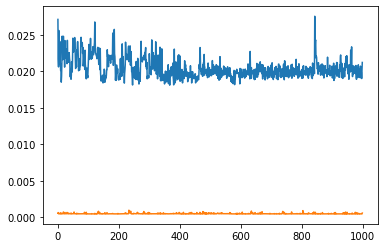

In [21]:
import matplotlib.pyplot as plt

plt.plot(t_our.repeat(repeat=1000, number=10))

plt.plot(t_lru.repeat(repeat=1000, number=10))

**Вывод:** ну не очень, но смотря на `cProfile` можно попробовать понять почему

In [22]:
## Память 

In [23]:
%load_ext memory_profiler

The memory_profiler extension is already loaded. To reload it, use:
  %reload_ext memory_profiler


In [27]:
%memit fact_l(1000)
%memit fact(1000)

#немного подозрительно

peak memory: 83.91 MiB, increment: 0.00 MiB
peak memory: 83.91 MiB, increment: 0.00 MiB


In [25]:
print(fact_l.cache_info())

CacheInfo(hits=81111126, misses=1000, maxsize=20, currsize=20)


### Дополнительное задание (0.2 балла)

Дополните декоратор @cached так, чтобы не пересчитывать функцию при изменения ее состояния (например, она использовала глобальную переменную)

In [ ]:
<your code here>

## 2. Декоратор @checked (0.3 балла)

Напишите декоратор, который будет вызывать исключение (raise TypeError), если в него переданы аргументы не тех типов.

<b>P. S.</b> Разберитесь с модулем typing.

<b>Рекомендации:</b>

* Декорируйте wrapper с @functools.wraps(func)
* Чтобы кинуть иключение используйте конструкцию типа:
<code>
if < some_condtion >:
    raise TypeError
</code>

In [3]:
import functools
import sys

def checked(*types):
    def decorator(f):
        @functools.wraps(f)
        def wrapper(*args):
            for arg_, types_ in zip(args, types):
                    if isinstance(arg_, types_):
                        continue
                    else:
                        print("bad")
                        raise TypeError
            return f(*types)
        return wrapper
    return decorator    

#### Проверьте использование декоратора

In [87]:
from typing import List

# Пример
@checked(str, int, list)
def strange_func(a: str, b: int, c: List):
    print("good")

In [88]:
# str int list - все должно быть хорошо
strange_func("string", 3, [1, 2, 3])

TypeError: strange_func() missing 3 required positional arguments: 'a', 'b', and 'c'

In [11]:
# вместо int'a передадим float
strange_func("other string", 3.5, [0, 9, 8])

bad


TypeError: 

In [12]:
# вместо ожидаемого листа передадим int
strange_func("other string", 3, 8)

bad


TypeError: 

## 3. Декоратор @Logger (0.4 балла)

Напишите полноценный logger для вызовов вашей функции. Декоратор должен иметь следующие опции:

* Выбор файла в который будет производиться запись: sys.stdout, sys.stderr, локальный файл (передается путь к файлу, если файла нет, то создать, иначе дописывать в конец).
* Формат записи в логера: "<i>index data time functio_name \*args \**kwargs result</i>"
* Логер должен быть один для всех функций.

<b>Рекомендации:</b>

* Декорируйте wrapper с @functools.wraps(func)
* Создайте отдельный класс Logger для работы с выводом данных вызовов функций в файл.

# ToDO
- надо ли оборочивать класс?

## Решение

In [14]:
import datetime
import functools
import sys

In [15]:
class Logger:
    def __init__(self):
        self.index = 0

    def __call__(self, func, filename, *args, **kwargs):
        time = str(datetime.datetime.now())
        func_name = func.__name__
        func_val = func(*args, **kwargs)
        out_str = "{} {} {} args: {} kwargs: {} result: {}".format(
            self.index,
            time,
            func_name,
            args,
            kwargs,
            func_val
        ).strip() + "\n"

        if filename in [sys.stdout, sys.stderr]:
            print(out_str, end="\r", file=filename)
        else:
            with open(filename, 'a') as f:
                f.write(out_str)
        self.index += 1
        return func_val

In [16]:
def logger(log_storage):
    logger_instance = Logger()

    def wrapped(func):
        @functools.wraps(func)
        def wrapper(*args, **kwargs):
            return logger_instance(
                func,
                log_storage,
                *args,
                **kwargs
            )

        return wrapper
    return wrapped

# Немного тестов

In [17]:
@logger(sys.stderr)
def stderr_test(*args, **kwargs):
    return len(args) + len(kwargs)


@logger('test.txt')
def file_test(*args, **kwargs):
    return len(args) + len(kwargs)


In [18]:
print(stderr_test())
print(stderr_test(2, mystr=["qwerty", "lol"]))

# print(file_test())
# print(file_test(3, myobj=()))

0
2


0 2020-03-11 17:27:18.940801 stderr_test args: () kwargs: {} result: 0
1 2020-03-11 17:27:18.941141 stderr_test args: (2,) kwargs: {'mystr': ['qwerty', 'lol']} result: 2


## Решение без класса

Так бы выглядело решение без класса, с использованием области видимости `nonlocal`.

In [19]:
def logger(filename):
    index = 0
    def decorator(func):
        def wrapped(*args, **kwargs):
            nonlocal index
            time = str(datetime.datetime.now())
            func_name = func.__name__
            func_val = func(*args, **kwargs)
            out_str = "{} {} {} args: {} kwargs: {} result: {}".format(
                index,
                time,
                func_name,
                args,
                kwargs,
                func_val
            ).strip() + "\n"
            
            if filename in [sys.stdout, sys.stderr]:
                print(out_str, end="\r", file=filename)
            else:
                with open(filename, 'a') as f:
                    f.write(out_str)
            index += 1
            return func_val
        return wrapped
    return decorator

## Немного тестов

In [20]:
print(stderr_test())
print(stderr_test(2, mystr=["qwerty", "lol"]))

# print(file_test())
# print(file_test(3, myobj=()))

0
2


2 2020-03-11 17:27:21.006448 stderr_test args: () kwargs: {} result: 0
3 2020-03-11 17:27:21.006945 stderr_test args: (2,) kwargs: {'mystr': ['qwerty', 'lol']} result: 2


# Test Cells

In [130]:
# Список чисел в список строк
f_1 = lambda x: [str(i) for i in x]
f_2 = lambda x: list(map(str, x))

In [131]:
from functools import reduce

def multiply(a, b):
    return a*b

reduce(multiply, range(1,6))

120

In [133]:
filter(bool, range(3)) # [1, 2]